## This Notebook handels the Dualmyo Database 

In this notebook the paper EMG-based online classification of gestures with recurrent neural networks will be copied

8 Gestures, 16 Channel-EMG placed on the the wirst and 110 repitions, 5 recordings sessions, 200Hz, 95 synthetic sequences

Each sequence has a lenth of about 50sec (about 10000 timestemps)

https://zenodo.org/record/1320922#.Y9DlgtLMJhE

paper: EMG-based online classification of gestures with recurrent neural networks

In [2]:
import pickle
import gzip
import os
import numpy as np
import random

In [3]:
opsys = "Windows"
if opsys == "Linux":
    path = os.path.abspath("/home/finn/Dokumente/EMG_data/UC2018 DualMyo Hand Gesture Dataset/dualmyo_dataset.pkl")
elif opsys == "Windows": 
    path = os.path.abspath("C:/Users/Finn/Jupyter Notebooks/EMG_AI_testing/Dualmyo_database/UC2018 DualMyo Hand Gesture Dataset/dualmyo_dataset.pkl")

In [4]:
with open(path, 'rb') as f:
    data = pickle.load(f)

# Extract independant and dependant data 
## independant data like: samples, length, EMG-channels

In [4]:
x, y = data[0], data[1]
x = np.concatenate([sample.reshape(((1,) + sample.shape)) for sample in x])
y = np.array(y)
x.shape

(881, 400, 20)

In [5]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([110, 110, 110, 110, 111, 110, 110, 110], dtype=int64))

In [6]:
np.where(y == 0)

(array([  5,  14,  16,  30,  33,  41,  53,  63,  64,  72,  82,  90, 103,
        105, 116, 120, 134, 138, 149, 155, 163, 171, 176, 190, 193, 206,
        215, 219, 231, 237, 244, 249, 258, 269, 278, 287, 293, 296, 306,
        318, 324, 335, 341, 351, 358, 360, 369, 378, 384, 397, 403, 414,
        418, 427, 434, 446, 450, 456, 467, 479, 481, 493, 503, 510, 515,
        524, 530, 539, 546, 559, 564, 572, 582, 586, 595, 607, 608, 620,
        626, 639, 646, 652, 656, 664, 672, 680, 692, 700, 711, 716, 724,
        732, 737, 752, 758, 768, 769, 780, 792, 797, 806, 816, 821, 825,
        830, 843, 848, 859, 869, 870], dtype=int64),)

## Split data indices into train, val and test data 

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

train_ration, val_ratio, test_ratio = 0.6, 0.2, 0.2
indices = np.arange(len(y))
sss = StratifiedShuffleSplit(random_state=42, test_size=val_ratio+test_ratio).split(indices, y)
indx_train, indx_test = next(sss)
sss = StratifiedShuffleSplit(random_state=42, test_size=test_ratio/(test_ratio + val_ratio)).split(indx_test, y[indx_test])
indx_test, indx_val = next(sss)
indx_train.shape, indx_test.shape, indx_val.shape

((528,), (176,), (177,))

## Generate sequences consisting of n = 8 consecutive gestures

In [8]:
# set random seeds for repuducability
random.seed(42)
np.random.seed(42)
def return_sequence(x, y, indices, n=8): 
    # new shape: 66, 3200, 20
    length = len(x[indices]) // n
    indices = indices[(len(indices) % 8):]
    indx_shuf = indices.reshape(length, n)
    return x[indx_shuf].reshape(length, -1, x.shape[2]), np.repeat(y[indx_shuf], x.shape[1], axis=1)

x_train, y_train = return_sequence(x, y, indx_train)
x_test, y_test = return_sequence(x, y, indx_test)
x_val, y_val = return_sequence(x, y, indx_val)
x_train.shape, x_val.shape, x_test.shape

((66, 3200, 20), (22, 3200, 20), (22, 3200, 20))

## Sliding windows on each sequence
##### because step=1 input array and output have same dimensions except for one window (first)

In [9]:
from numpy.lib.stride_tricks import sliding_window_view

def window_data(ary, length=100, step=1):
    """ Please make sure sensors are on col, time in row """
    if len(ary.shape) >= 2:
        return sliding_window_view(ary,(length, ary.shape[1]))[::step, 0]
    else:
        return sliding_window_view(ary, length)[::step]
    

X1 = np.vstack([window_data(x, 100) for x in x_train])
X2 = np.vstack([window_data(x, 100) for x in x_val])
X3 = np.vstack([window_data(x, 100) for x in x_test])
X1.shape

(204666, 100, 20)

In [10]:
y_train.shape

(66, 3200)

In [11]:
# keep targets the same length as corresponding X
Y1 = np.ravel([[np.argmax(np.bincount(win)) for win in window_data(y, 100)] for y in y_train])
Y2 = np.ravel([[np.argmax(np.bincount(win)) for win in window_data(y, 100)] for y in y_val])
Y3 = np.ravel([[np.argmax(np.bincount(win)) for win in window_data(y, 100)] for y in y_test])
Y1.shape

(204666,)

In [12]:
# One Hot Encode Targets
from sklearn.preprocessing import OneHotEncoder

def check_data(function): 
    def wrapper(*args): 
        for arg in args: 
            if np.max(np.unique(arg)) <= 1:
                raise ValueError("Data probably already One Hot encoded")
        else:
            return function(*args)
    return wrapper
        

@check_data
def ohe_targets(train_targets, *targets): 
    encoder = OneHotEncoder()
    encoder.fit(train_targets)
    train_targets = encoder.transform(train_targets)
    n_tar = []
    for tar in targets: 
        n_tar.append(encoder.transform(tar))
    return train_targets.toarray(), *[x.toarray() for x in n_tar]

# a, b, c = [np.arange(5).reshape(-1, 1) for i in range(3)]
# a, b, c = ohe_targets(a, b, c)
# a, b, c
Y1, Y2, Y3 = ohe_targets(Y1.reshape(-1, 1), Y2.reshape(-1, 1), Y3.reshape(-1, 1))
Y1.shape

(204666, 8)

## Feature Extraction
#### Standard deviation on every window and drop of useless cols

In [13]:
def std(ary): 
    ary = np.delete(ary, [0, 1, 10, 11], axis=2)
    return np.std(ary, axis=1)

X1 = std(X1)
X2 = std(X2)
X3 = std(X3)
X1.shape, X2.shape, X3.shape

((204666, 16), (68222, 16), (68222, 16))

### Feature Scaling 


In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X1)

X1 = scaler.transform(X1)
X2 = scaler.transform(X2)
X3 = scaler.transform(X3)
X3.shape

(68222, 16)

## LSTM Model for online learning
#### stolen from: https://towardsdatascience.com/lstm-for-predictive-maintenance-on-pump-sensor-data-b43486eb3210

In [15]:
if True: 
    xtrain = X1.reshape(X1.shape[0], 1, X1.shape[1])
    ytrain, ytrain_hot = np.argmax(Y1, axis=1), Y1
    xval = X2.reshape(X2.shape[0], 1, X2.shape[1])
    yval, yval_hot = np.argmax(Y2, axis=1), Y2
    xtest = X3.reshape(X3.shape[0], 1, X3.shape[1])
    ytest, ytest_hot = np.argmax(Y3, axis=1), Y3

In [16]:
import tensorflow as tf
from keras.layers import LSTM, Dropout, Dense


# form: samples (0), timesteps (1), sensor (2)
inputs = tf.keras.Input(shape=(xtrain.shape[1], xtrain.shape[2]))
x = LSTM(50, activation="relu", input_shape=(xtrain.shape[1], xtrain.shape[2]), return_sequences=True)(inputs)
x = LSTM(50, activation="relu")(x)
out_signal = Dense(1, name="signal_out")(x)
out_class = Dense(8, activation="softmax", name="class_out")(x)

model = tf.keras.Model(inputs=inputs, outputs=[out_signal, out_class])

model.compile(loss={"signal_out": "mean_squared_error", 
                   "class_out": "categorical_crossentropy"}, 
             optimizer="adam", 
             metrics={"class_out": "acc"})
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 16)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 1, 50)        13400       ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 50)           20200       ['lstm[0][0]']                   
                                                                                                  
 signal_out (Dense)             (None, 1)            51          ['lstm_1[0][0]']                 
                                                                                              

In [17]:
xtrain.shape, ytrain_hot.shape

((204666, 1, 16), (204666, 8))

In [18]:
history = model.fit(xtrain, ytrain_hot, epochs=20, batch_size=32, validation_data=(xval, yval_hot), shuffle=False)

Epoch 1/20
6396/6396 [==============================] - 16s 2ms/step - loss: 0.5710 - signal_out_loss: 0.1255 - class_out_loss: 0.4454 - class_out_acc: 0.8372 - val_loss: 0.4636 - val_signal_out_loss: 0.1216 - val_class_out_loss: 0.3420 - val_class_out_acc: 0.8749
Epoch 2/20
6396/6396 [==============================] - 14s 2ms/step - loss: 0.3900 - signal_out_loss: 0.1174 - class_out_loss: 0.2725 - class_out_acc: 0.8978 - val_loss: 0.4250 - val_signal_out_loss: 0.1206 - val_class_out_loss: 0.3044 - val_class_out_acc: 0.8880
Epoch 3/20
6396/6396 [==============================] - 14s 2ms/step - loss: 0.3605 - signal_out_loss: 0.1143 - class_out_loss: 0.2461 - class_out_acc: 0.9040 - val_loss: 0.3985 - val_signal_out_loss: 0.1098 - val_class_out_loss: 0.2887 - val_class_out_acc: 0.8924
Epoch 4/20
6396/6396 [==============================] - 15s 2ms/step - loss: 0.3417 - signal_out_loss: 0.1120 - class_out_loss: 0.2296 - class_out_acc: 0.9091 - val_loss: 0.3839 - val_signal_out_loss: 0.11

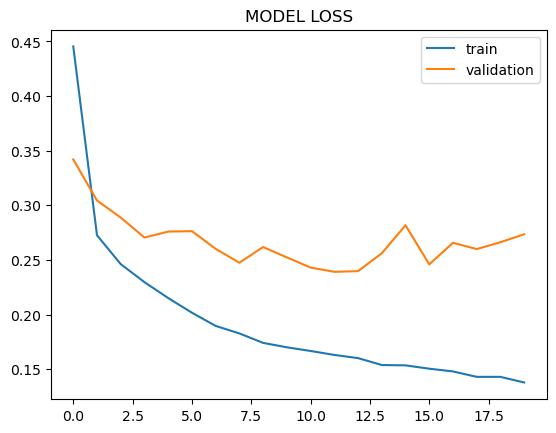

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history["class_out_loss"])
plt.plot(history.history["val_class_out_loss"])
plt.title("MODEL LOSS")
plt.legend(["train", "validation"])

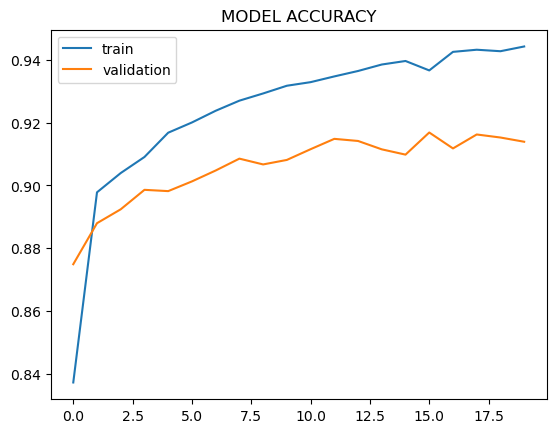

In [20]:
plt.plot(history.history["class_out_acc"])
plt.plot(history.history["val_class_out_acc"])
plt.title("MODEL ACCURACY")
plt.legend(["train", "validation"])

In [21]:
yhat, yclass = model.predict(xtest)

2132/2132 [==============================] - 2s 934us/step


In [22]:
Yclass = np.argmax(yclass, axis=1)

In [23]:
ytest

array([7, 7, 7, ..., 1, 1, 1], dtype=int64)

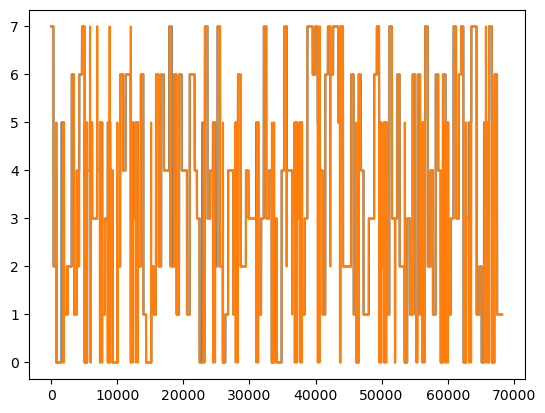

In [24]:
plt.plot(ytest)
plt.plot(Yclass)

In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score

accuracy_score(ytest, Yclass)

0.928718008853449

In [26]:
# form: samples (0), timesteps (1), sensor (2)

inputs = tf.keras.Input(shape=(xtrain.shape[1], xtrain.shape[2]))
x = Dense(400, activation="tanh", input_shape=(xtrain.shape[1], x_train.shape[2]))(inputs)
# x = LSTM(50, activation="relu", input_shape=(xtrain.shape[1], xtrain.shape[2]), return_sequences=True)(inputs)
x = LSTM(256, activation="tanh", input_shape=(xtrain.shape[1], xtrain.shape[2]))(x)
out_signal = Dense(1, name="signal_out")(x)
out_class = Dense(8, activation="softmax", name="class_out")(x)

model = tf.keras.Model(inputs=inputs, outputs=[out_class, out_signal])

model.compile(loss={"class_out": "categorical_crossentropy", 
                   "signal_out": "mean_squared_error"}, 
             optimizer="adam", 
             metrics={"class_out": "acc"})
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1, 16)]      0           []                               
                                                                                                  
 dense (Dense)                  (None, 1, 400)       6800        ['input_2[0][0]']                
                                                                                                  
 lstm_2 (LSTM)                  (None, 256)          672768      ['dense[0][0]']                  
                                                                                                  
 class_out (Dense)              (None, 8)            2056        ['lstm_2[0][0]']                 
                                                                                            

In [27]:
history = model.fit(xtrain, ytrain_hot, epochs=20, batch_size=32, validation_data=(xval, yval_hot), shuffle=False)

Epoch 1/20
6396/6396 [==============================] - 25s 4ms/step - loss: 0.5069 - class_out_loss: 0.3787 - signal_out_loss: 0.1281 - class_out_acc: 0.8669 - val_loss: 0.7373 - val_class_out_loss: 0.5858 - val_signal_out_loss: 0.1514 - val_class_out_acc: 0.8173
Epoch 2/20
6396/6396 [==============================] - 23s 4ms/step - loss: 0.4371 - class_out_loss: 0.3184 - signal_out_loss: 0.1187 - class_out_acc: 0.8828 - val_loss: 0.5409 - val_class_out_loss: 0.4220 - val_signal_out_loss: 0.1190 - val_class_out_acc: 0.8677
Epoch 3/20
6396/6396 [==============================] - 23s 4ms/step - loss: 0.4062 - class_out_loss: 0.2901 - signal_out_loss: 0.1161 - class_out_acc: 0.8896 - val_loss: 0.5698 - val_class_out_loss: 0.4493 - val_signal_out_loss: 0.1204 - val_class_out_acc: 0.8663
Epoch 4/20
6396/6396 [==============================] - 22s 3ms/step - loss: 0.3932 - class_out_loss: 0.2743 - signal_out_loss: 0.1190 - class_out_acc: 0.8953 - val_loss: 0.4955 - val_class_out_loss: 0.380

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history["class_out_loss"])
plt.plot(history.history["val_class_out_loss"])
plt.title("MODEL LOSS")
plt.legend(["train", "validation"])

In [ ]:
plt.plot(history.history["class_out_acc"])
plt.plot(history.history["val_class_out_acc"])
plt.title("MODEL ACCURACY")
plt.legend(["train", "validation"])